## Contenu :
### 1.  ElasticNetCV
### 2.  Polynomial Features & Linear Regression
### 3.  Random Forest Regression

Ces algorithmes ont été essayés avec de nombreuses combinaisons de données et de variables, comme détaillé dans le rapport. Ce notebook contient le code uniquement pour le modèle finalement retenu  pour chaque algorithme. (Le code de toutes les combinaisons testées se trouve dans le branch "Deborah" du repo Github)

_____________________________________________________________________________________________________________


## 1. ElasticNetCV

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production solaire quotidienne de la région Nouvelle Aquitaine (région la plus productive) du 2016 au 2019 ont été utilisées, avec les variables explicatives suivantes: année, mois, rayonnement solaire moyen, vitesse du vent moyenne, temperature moyenne/ maximale/ minimale quotidienne 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV

In [22]:
#import des données (préparée dans le notebook "Visualisation")
df = pd.read_csv("tempdata_2016_2019.csv")
# on prend Nouvelle Aquitaine
NAQ = df.loc[(df["Région"] == "Nouvelle-Aquitaine")]
NAQ.info()
# en selectionnant une seule région on n'a pas beaucoup de données : 1461 lignes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 10227 to 11687
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Région                          1461 non-null   object 
 1   Annee                           1461 non-null   int64  
 2   Month                           1461 non-null   int64  
 3   Date                            1461 non-null   int64  
 4   Day                             1461 non-null   object 
 5   Eolien_sum(MW)                  1461 non-null   float64
 6   Vitesse_vent_mean(m/s)          1461 non-null   float64
 7   Solaire_sum(MW)                 1461 non-null   float64
 8   Rayonnement_solaire_mean(W/m2)  1461 non-null   float64
 9   Consommation-sum(MW)            1461 non-null   float64
 10  TMin (°C)                       1461 non-null   float64
 11  TMax (°C)                       1461 non-null   float64
 12  TMoy (°C)                    

In [23]:
NAQ = NAQ.drop(['Région','Day', 'Date', 'Eolien_sum(MW)','Consommation-sum(MW)'], axis=1)
# on remplace la variable categorielle "Annee" par la production moyenne pour cet année
# (pour indiquer l'influence attendue de cette variable sur la production)
means = []
for year in NAQ["Annee"].unique():    
    means.append(NAQ['Solaire_sum(MW)'].loc[NAQ["Annee"] == year].mean())
print([round(num) for num in means])

[2104, 2257, 2788, 3016]


In [24]:
# on remplace la variable categorielle "Month" par la production moyenne pour chaque mois
# (pour indiquer l'influence attendue de cette variable sur la production) 
means = []
for month in NAQ["Month"].unique():    
    means.append(NAQ['Solaire_sum(MW)'].loc[NAQ["Month"] == month].mean())
print([round(num) for num in means])

[955, 1812, 2419, 3026, 3361, 3597, 3752, 3859, 3069, 2264, 1407, 938]


In [25]:
encode = {"Annee": {2016: 2104, 2017: 2257, 2018: 2788, 2019:3016}, 
          "Month": {1: 955, 2: 1812, 3: 2419, 4: 3026, 5:3361, 6:3597, 
                    7:3752, 8:3859, 9:3069, 10:2264, 11: 1407, 12:938}}
NAQ = NAQ.replace(encode)
NAQ.head(3)

,Annee,Month,Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),TMin (°C),TMax (°C),TMoy (°C)
10227,2104,955,8.102857,1042.0,67.292857,3.32,13.58,8.45
10228,2104,955,8.507500,810.0,50.072500,7.63,11.82,9.73
10229,2104,955,8.775000,179.0,13.750000,5.44,11.67,8.56


In [26]:
scaler = preprocessing.StandardScaler().fit(NAQ)
NAQ[NAQ.columns] = pd.DataFrame(scaler.transform(NAQ), index=NAQ.index)

# Separer target & variables explicatives
data = NAQ.drop('Solaire_sum(MW)', axis=1)
target = NAQ['Solaire_sum(MW)']

# Separer train & test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

# Application du model : ElasticNetCV
model_en = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))
model_en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [27]:
# Afficher les RMSE & scores
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

rmse train : 0.3671967498353476
rmse test : 0.38863329009180053
score train : 0.8669784812365665
score test : 0.8399132321940804


In [28]:
# afficher les predictions
moy = scaler.mean_[0]
ec = scaler.scale_[0]
print("moyenne :", moy)
print("ecart-type :", ec)

predictions = pd.DataFrame({'true': (y_test*ec)+moy, 'predicted': np.round((pred_test*ec)+moy)}, 
             index=X_test.index)
predictions.head(7)

moyenne : 2540.950718685832
ecart-type : 373.63074266303784


,true,predicted
11091,2345.636464,2470.0
10588,2272.369861,2096.0
11149,3199.544387,3112.0
10388,2192.324141,2214.0
10742,2512.507020,2622.0
10782,2525.804517,2623.0
11352,2161.557382,2219.0


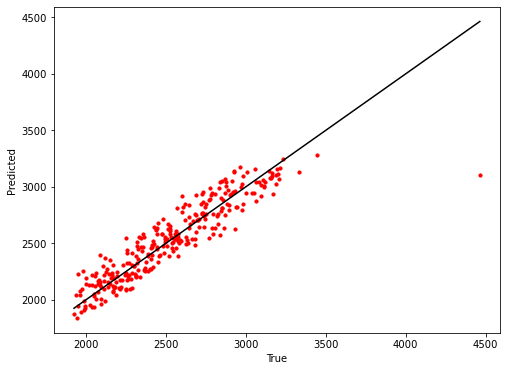

In [29]:
# afficher un nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(predictions.true, predictions.predicted,color='red', s=10)
plt.plot((predictions.true.min(), predictions.true.max()), (predictions.true.min(), predictions.true.max()),color='k')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.savefig("Pictures/#41_-_SolarLR_predictions.png", dpi=150, bbox_inches='tight')
plt.show();

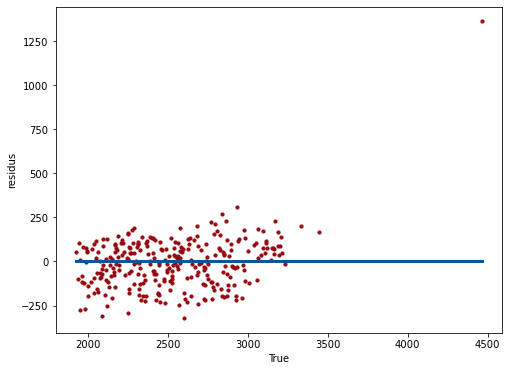

In [30]:
# afficher la distribution des résidus
residus = predictions.true - predictions.predicted
plt.figure(figsize=(8, 6))
plt.scatter(predictions.true, residus, color='#980a10', s=10)
plt.plot((predictions.true.min(), predictions.true.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('True')
plt.ylabel('residus')
plt.savefig("Pictures/#42_-_SolarLR_residus.png", dpi=150, bbox_inches='tight')
plt.show();


## 2. Polynomial Features + Linear Regression

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production solaire quotidienne de la région Nouvelle Aquitaine (région la plus productive) du 2016 au 2019 ont été utilisées, avec les variables explicatives suivantes: année, mois, rayonnement solaire moyen, vitesse du vent moyenne 

In [11]:
# supprimer les colonnes que nous n'allons pas utiliser
Data = NAQ.drop(['TMin (°C)','TMax (°C)','TMoy (°C)'], axis=1)
Data.head(3)

,Annee,Month,Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2)
10227,-1.169472,-1.548738,2.221330,-1.046128,-1.049537
10228,-1.169472,-1.548738,2.527167,-1.208028,-1.245055
10229,-1.169472,-1.548738,2.729349,-1.648366,-1.657457


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

scaler = preprocessing.StandardScaler()
degree=4
model=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [13]:
# Evaluation du Model
print('score train :', model.score(X_train, y_train))
print('score test :', model.score(X_test, y_test))

pred = model.predict(X_train)
pred_test = model.predict(X_test)

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

score train : 0.9377781072139327
score test : 0.8456583723309442
rmse train : 0.25113629714279884
rmse test : 0.38159600482209255


In [15]:
# Evaluation du model par validation croisée à 4 échantillons.
from sklearn.model_selection import cross_validate
print(cross_validate(model, X_train, y_train, return_train_score=True, cv=4)['train_score'].mean())
print(cross_validate(model, X_train, y_train, return_train_score=True, cv=4)['test_score'].mean())

0.9465943319875645
0.8306950425937047


## 3. Random Forest Regression

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production solaire quotidienne de la région Nouvelle Aquitaine (région la plus productive) du 2016 au 2019 ont été utilisées, avec les variables explicatives suivantes: année, mois, rayonnement solaire moyen, vitesse du vent moyenne, temperature moyenne, min & max

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Separer target & variables explicatives
data = NAQ.drop('Solaire_sum(MW)', axis=1)
target = NAQ['Solaire_sum(MW)']

# Separer train & test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

# création de RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
rfr.fit(X_train, y_train) 

# prédiction sur train set & calculation RMSE et R2 score
pred_train= rfr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))
print(r2_score(y_train, pred_train))

# prédiction sur test set & calculation RMSE et R2 score
pred_test = rfr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test)))
print(r2_score(y_test, pred_test))

0.11198466583832585
0.9876279586766995
0.2921831220225105
0.9095131045235694


In [19]:
# chercher les meilleurs parametres
from sklearn import model_selection
rfr = RandomForestRegressor(random_state=22)
parametres = {'n_estimators':[50, 100, 250, 500, 1000, 1500],'max_features': ['auto', 'sqrt'],'max_depth':[2, 4, 8]}
grid_search = model_selection.GridSearchCV(estimator=rfr, param_grid=parametres, scoring='r2', cv = 5)
grille = grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 1000}


In [20]:
# prédiction sur train set & calculation RMSE et R2 score
pred_train= grid_search.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))
print(r2_score(y_train, pred_train))

# prédiction sur test set & calculation RMSE et R2 score
pred_test = grid_search.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test)))
print(r2_score(y_test, pred_test))

0.17044793250620505
0.9713379189007656
0.29290223616211863
0.9090671480261378
